# HAR Model Training Pipeline

This notebook trains a Random Forest classifier on the HAR dataset with:
- **70:30 train/test split** (group-aware to prevent data leakage)
- **5-class classification**: WALK, RUN, UPSTAIRS, DOWNSTAIRS, IDLE
- **Clean feature set** (no metadata columns)

In [15]:
# Configuration and Data Loading
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
import matplotlib.pyplot as plt
import joblib
import datetime as dt

# Configuration
IN_PATH = "./out/features_trainable_5cls.csv" 
OUT_DIR = "./out"
TEST_SIZE = 0.30  # 70:30 train/test split
RANDOM_STATE = 42
USE_GROUP_SPLIT = True  # Prevent data leakage across files

# Create output directory
os.makedirs(OUT_DIR, exist_ok=True)

# Load data
print("📊 Loading training data...")
df = pd.read_csv(IN_PATH)

# Auto-detect label column
LABEL_COL = None
for cand in ["label_final_5cls", "label", "label_auto_5cls"]:
    if cand in df.columns:
        LABEL_COL = cand
        break

if LABEL_COL is None:
    raise ValueError("❌ No label column found. Expected: label_final_5cls, label, or label_auto_5cls")

print(f"✅ Data loaded: {df.shape[0]:,} samples, {df.shape[1]} columns")
print(f"✅ Label column: {LABEL_COL}")
print(f"\n📋 Class distribution:")
print(df[LABEL_COL].value_counts().sort_index())

df.head(3)

📊 Loading training data...
✅ Data loaded: 7,247 samples, 20 columns
✅ Label column: label

📋 Class distribution:
label
DOWNSTAIRS    1249
IDLE          1212
RUN           1306
UPSTAIRS      1739
WALK          1741
Name: count, dtype: int64


,lin_acc_mag_dom_freq,lin_acc_mag_rms,vert_horiz_ratio,vert_lin_rms,horiz_lin_rms,lin_acc_mag_band05_5Hz,gyro_mag_rms,lin_acc_mag_spec_entropy,vert_lin_mean,vert_impulse,vert_pos_impulse,vert_neg_impulse,vert_impulse_ratio,vert_p95,vert_p05,vert_peak_ratio,vjerk_rms,vert_balance_bp,peak_balance_bp,label
0,2.474748,5.691099,0.854429,3.696945,4.326801,7833.623626,2.808906,0.521149,-1.125216,-2.273395,1.499133,-3.772527,0.397382,4.500975,-7.201538,0.625002,45.457745,-0.316204,-0.135934,DOWNSTAIRS
1,0.989899,6.185855,0.544952,2.960008,5.431680,17291.158053,2.602030,0.601304,-0.490525,-0.991060,1.767274,-2.758334,0.640703,3.606363,-6.337401,0.569060,53.499067,-0.481609,-0.107081,DOWNSTAIRS
2,2.999395,5.422606,0.956067,3.747297,3.919493,7604.557972,2.183151,0.611251,1.724028,3.448751,4.798724,-1.349972,3.554684,7.067998,-3.120387,2.265103,60.935543,0.098150,-0.003334,DOWNSTAIRS


## 🔄 Train/Test Split (70:30 with Group-Aware)

In [16]:
print("🔄 Performing train/test split...")
print(f"Split ratio: {(1-TEST_SIZE)*100:.0f}% train, {TEST_SIZE*100:.0f}% test")

# Check available columns for group-aware splitting
print(f"\n📋 Available columns: {list(df.columns)}")

# Look for potential grouping columns
potential_group_cols = [col for col in df.columns if any(keyword in col.lower() 
                       for keyword in ['file', 'source', 'group', 'participant', 'subject'])]
print(f"📋 Potential grouping columns: {potential_group_cols}")

if USE_GROUP_SPLIT and potential_group_cols:
    # Use the first available grouping column
    group_col = potential_group_cols[0]
    print(f"🔄 Using '{group_col}' for group-aware splitting")
    
    print(f"📁 Found {df[group_col].nunique()} unique groups")
    
    # Create group-level labels (mode of each group)
    group_level = (
        df.groupby(group_col)
          .agg(group_label=(LABEL_COL, lambda s: s.mode().iat[0]))
          .reset_index()
    )
    
    print(f"📋 Group-level class distribution:")
    print(group_level["group_label"].value_counts().sort_index())
    
    # Handle classes with insufficient groups (< 2 groups)
    always_train_groups = set()
    rest = group_level.copy()
    
    while True:
        counts = rest["group_label"].value_counts()
        bad_classes = counts[counts < 2].index.tolist()
        if not bad_classes:
            break
        # Move groups of classes with < 2 groups to training set
        move_groups = set(rest.loc[rest["group_label"].isin(bad_classes), group_col])
        always_train_groups |= move_groups
        rest = group_level[~group_level[group_col].isin(always_train_groups)].reset_index(drop=True)
        if rest.empty:
            break
    
    if always_train_groups:
        print(f"⚠️  {len(always_train_groups)} groups moved to training (classes with <2 groups)")
    
    # Perform stratified split at group level
    if rest.empty:
        train_groups = set(group_level[group_col])
        test_groups = set()
        print("⚠️  All groups assigned to training set")
    else:
        sss = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
        train_idx, test_idx = next(sss.split(rest[[group_col]], rest["group_label"]))
        train_groups = set(rest.iloc[train_idx][group_col]) | always_train_groups
        test_groups = set(rest.iloc[test_idx][group_col])
    
    # Create train/test DataFrames
    assert train_groups.isdisjoint(test_groups), "❌ Group overlap detected!"
    train_df = df[df[group_col].isin(train_groups)].copy()
    test_df = df[df[group_col].isin(test_groups)].copy()
    
    print(f"✅ Group-aware split completed:")
    print(f"   Training groups: {len(train_groups)}")
    print(f"   Test groups: {len(test_groups)}")
    
elif USE_GROUP_SPLIT and not potential_group_cols:
    print("⚠️  No grouping columns found, falling back to standard split")
    USE_GROUP_SPLIT = False

if not USE_GROUP_SPLIT:
    # Standard stratified split
    train_df, test_df = train_test_split(
        df, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=df[LABEL_COL]
    )
    print("✅ Standard stratified split completed")

# Display split results
print(f"\n📊 Final split results:")
print(f"   Training: {train_df.shape[0]:,} samples ({train_df.shape[0]/df.shape[0]*100:.1f}%)")
print(f"   Test: {test_df.shape[0]:,} samples ({test_df.shape[0]/df.shape[0]*100:.1f}%)")

print(f"\n📋 Training set class distribution:")
train_dist = train_df[LABEL_COL].value_counts(normalize=True) * 100
for cls in sorted(train_dist.index):
    print(f"   {cls}: {train_dist[cls]:.1f}%")

print(f"\n📋 Test set class distribution:")
if len(test_df) > 0:
    test_dist = test_df[LABEL_COL].value_counts(normalize=True) * 100
    for cls in sorted(test_dist.index):
        print(f"   {cls}: {test_dist[cls]:.1f}%")
else:
    print("   (No test samples)")

# Save train/test splits
suffix = "_group" if USE_GROUP_SPLIT else ""
train_path = os.path.join(OUT_DIR, f"train_5cls.csv{suffix}")
test_path = os.path.join(OUT_DIR, f"test_5cls.csv{suffix}")

train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)

print(f"\n💾 Saved splits:")
print(f"   Training: {train_path}")
print(f"   Test: {test_path}")

🔄 Performing train/test split...
Split ratio: 70% train, 30% test

📋 Available columns: ['lin_acc_mag_dom_freq', 'lin_acc_mag_rms', 'vert_horiz_ratio', 'vert_lin_rms', 'horiz_lin_rms', 'lin_acc_mag_band05_5Hz', 'gyro_mag_rms', 'lin_acc_mag_spec_entropy', 'vert_lin_mean', 'vert_impulse', 'vert_pos_impulse', 'vert_neg_impulse', 'vert_impulse_ratio', 'vert_p95', 'vert_p05', 'vert_peak_ratio', 'vjerk_rms', 'vert_balance_bp', 'peak_balance_bp', 'label']
📋 Potential grouping columns: []
⚠️  No grouping columns found, falling back to standard split
✅ Standard stratified split completed

📊 Final split results:
   Training: 5,072 samples (70.0%)
   Test: 2,175 samples (30.0%)

📋 Training set class distribution:
   DOWNSTAIRS: 17.2%
   IDLE: 16.7%
   RUN: 18.0%
   UPSTAIRS: 24.0%
   WALK: 24.0%

📋 Test set class distribution:
   DOWNSTAIRS: 17.2%
   IDLE: 16.7%
   RUN: 18.0%
   UPSTAIRS: 24.0%
   WALK: 24.0%

💾 Saved splits:
   Training: ./out/train_5cls.csv
   Test: ./out/test_5cls.csv


In [17]:
## 🧹 Feature Preparation

In [18]:
print("🧹 Preparing features for training...")

# Define metadata columns to exclude
META_COLS = {
    "source_file", "start_time", "end_time",
    "expected_file_class", "expected_file_group",
    "label", "label_auto_5cls", "label_final_5cls",
    "file_key"  # Important: exclude to prevent data leakage
}

# Find which metadata columns are present
meta_present = [c for c in META_COLS if c in train_df.columns]
feature_cols = [c for c in train_df.columns if c not in meta_present]

print(f"📋 Column analysis:")
print(f"   Total columns: {len(train_df.columns)}")
print(f"   Metadata columns found: {len(meta_present)} {meta_present}")
print(f"   Feature columns: {len(feature_cols)}")

def prepare_features(df, feature_cols):
    """Prepare feature matrix with proper data types and missing value handling"""
    X = df[feature_cols].copy()
    
    # Convert to numeric and handle missing values
    for col in feature_cols:
        if not np.issubdtype(X[col].dtype, np.number):
            X[col] = pd.to_numeric(X[col], errors="coerce")
        if X[col].isna().any():
            X[col] = X[col].fillna(X[col].median())
    
    return X

# Prepare training and test features
X_train = prepare_features(train_df, feature_cols)
y_train = train_df[LABEL_COL].astype("category")

X_test = prepare_features(test_df, feature_cols) if len(test_df) > 0 else None
y_test = test_df[LABEL_COL].astype("category") if len(test_df) > 0 else None

print(f"✅ Features prepared:")
print(f"   Training: {X_train.shape}")
print(f"   Test: {X_test.shape if X_test is not None else 'None'}")
print(f"   Classes: {list(y_train.cat.categories)}")

# Display feature info
print(f"\n📊 First 5 features: {feature_cols[:5]}")
print(f"📊 Last 5 features: {feature_cols[-5:]}")

🧹 Preparing features for training...
📋 Column analysis:
   Total columns: 20
   Metadata columns found: 1 ['label']
   Feature columns: 19
✅ Features prepared:
   Training: (5072, 19)
   Test: (2175, 19)
   Classes: ['DOWNSTAIRS', 'IDLE', 'RUN', 'UPSTAIRS', 'WALK']

📊 First 5 features: ['lin_acc_mag_dom_freq', 'lin_acc_mag_rms', 'vert_horiz_ratio', 'vert_lin_rms', 'horiz_lin_rms']
📊 Last 5 features: ['vert_p05', 'vert_peak_ratio', 'vjerk_rms', 'vert_balance_bp', 'peak_balance_bp']


## 🤖 Model Training

🤖 Training Random Forest classifier...
   Training on 5,072 samples with 19 features...
✅ Training completed!

📊 Evaluating on 2,175 test samples...
✅ Balanced Accuracy: 0.9234 (92.34%)

📋 Classification Report:
✅ Training completed!

📊 Evaluating on 2,175 test samples...
✅ Balanced Accuracy: 0.9234 (92.34%)

📋 Classification Report:
              precision    recall  f1-score   support

  DOWNSTAIRS      0.876     0.811     0.842       375
        IDLE      1.000     1.000     1.000       364
         RUN      0.997     1.000     0.999       392
    UPSTAIRS      0.823     0.900     0.860       522
        WALK      0.946     0.906     0.926       522

    accuracy                          0.921      2175
   macro avg      0.929     0.923     0.925      2175
weighted avg      0.923     0.921     0.921      2175

              precision    recall  f1-score   support

  DOWNSTAIRS      0.876     0.811     0.842       375
        IDLE      1.000     1.000     1.000       364
         RUN

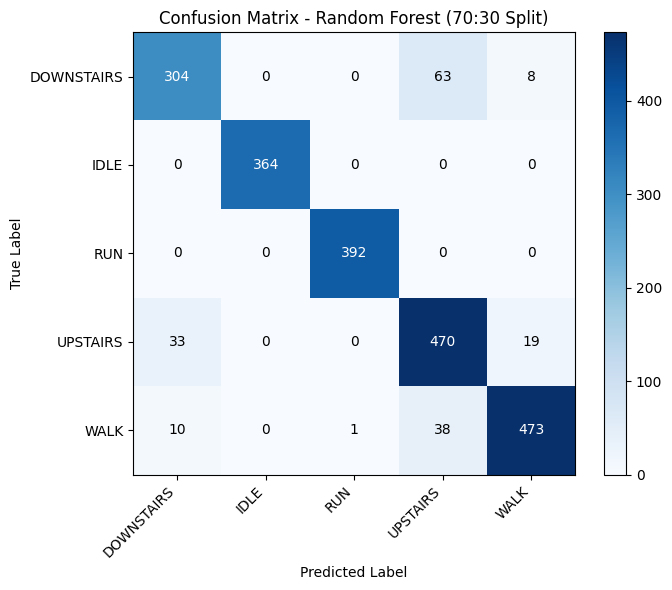


🎯 Top 10 Most Important Features:
    1. lin_acc_mag_dom_freq: 0.0895
    2. vert_p95: 0.0798
    3. vert_lin_rms: 0.0782
    4. vert_peak_ratio: 0.0779
    5. vert_p05: 0.0724
    6. vert_pos_impulse: 0.0722
    7. lin_acc_mag_rms: 0.0683
    8. vjerk_rms: 0.0673
    9. vert_neg_impulse: 0.0609
   10. gyro_mag_rms: 0.0567
   ... (showing top 10 of 19 features)


In [27]:
print("🤖 Training Random Forest classifier...")

# Configure Random Forest
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    max_features="sqrt",
    class_weight="balanced",
    n_jobs=-1,
    random_state=RANDOM_STATE
)

# Train the model
print(f"   Training on {X_train.shape[0]:,} samples with {X_train.shape[1]} features...")
rf.fit(X_train, y_train)
print("✅ Training completed!")

# Evaluate on test set (if available)
if X_test is not None and len(X_test) > 0:
    print(f"\n📊 Evaluating on {X_test.shape[0]:,} test samples...")
    
    y_pred = rf.predict(X_test)
    y_proba = rf.predict_proba(X_test)
    
    # Calculate metrics
    accuracy = balanced_accuracy_score(y_test, y_pred)
    print(f"✅ Balanced Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # Detailed classification report
    print(f"\n📋 Classification Report:")
    print(classification_report(y_test, y_pred, digits=3))
    
    # Confusion Matrix
    labels = sorted(y_train.cat.categories)
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    
    plt.figure(figsize=(8, 6))
    im = plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    
    plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
    plt.yticks(range(len(labels)), labels)
    plt.title("Confusion Matrix - Random Forest (70:30 Split)")
    
    # Add text annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center", 
                    fontsize=10, color="black" if cm[i, j] < cm.max()/2 else "white")
    
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️  No test set available for evaluation")

# Feature importance
print(f"\n🎯 Top 10 Most Important Features:")
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

for i, (_, row) in enumerate(feature_importance.head(10).iterrows()):
    print(f"   {i+1:2d}. {row['feature']}: {row['importance']:.4f}")
    
print(f"   ... (showing top 10 of {len(feature_cols)} features)")

In [28]:
## 💾 Model Saving

In [36]:
print("💾 Saving trained model...")

# Create model bundle with metadata
model_bundle = {
    "model": rf,
    "features": feature_cols,
    "label_col": LABEL_COL,
    "classes": list(y_train.cat.categories),
    "n_features": len(feature_cols),
    "train_samples": len(X_train),
    "test_samples": len(X_test) if X_test is not None else 0,
    "test_split": TEST_SIZE,
    "group_split": USE_GROUP_SPLIT,
    "random_state": RANDOM_STATE,
    "trained_at": dt.datetime.now().isoformat(timespec="seconds"),
    "model_type": "RandomForestClassifier",
    "model_params": rf.get_params()
}

# Add test accuracy if available
if X_test is not None and len(X_test) > 0:
    model_bundle["test_accuracy"] = accuracy

# Save model
model_path = os.path.join(OUT_DIR, "rf_5cls_clean.joblib")
joblib.dump(model_bundle, model_path)

print(f"✅ Model saved to: {model_path}")
print(f"📋 Model bundle contains:")
print(f"   - Trained RandomForest model")
print(f"   - {len(feature_cols)} feature names")
print(f"   - {len(model_bundle['classes'])} class labels")
print(f"   - Training metadata and parameters")
if X_test is not None:
    print(f"   - Test accuracy: {accuracy:.4f}")

💾 Saving trained model...
✅ Model saved to: ./out/rf_5cls_clean.joblib
📋 Model bundle contains:
   - Trained RandomForest model
   - 19 feature names
   - 5 class labels
   - Training metadata and parameters
   - Test accuracy: 0.9234


## 📱 ONNX Export (Optional)

In [34]:
# Optional: Export to ONNX for mobile deployment
try:
    print("📱 Exporting model to ONNX format...")
    
    # Check if skl2onnx is available
    try:
        from skl2onnx import convert_sklearn
        from skl2onnx.common.data_types import FloatTensorType
        import onnx
    except ImportError:
        print("⚠️  skl2onnx not installed. Run: pip install skl2onnx")
        print("   Skipping ONNX export...")
    else:
        # Also save for mobile deployment
        mobile_dir = "./mobile"
        os.makedirs(mobile_dir, exist_ok=True)

        mobile_bundle = {
            "classes": model_bundle["classes"],
            "features": feature_cols,
            "trained_at": model_bundle["trained_at"],
            "test_accuracy": model_bundle.get("test_accuracy", "N/A")
        }

        import json
        with open(os.path.join(mobile_dir, "rf_5cls_clean.meta.json"), "w") as f:
            json.dump(mobile_bundle, f, ensure_ascii=False, indent=2)

        print(f"✅ Mobile metadata saved to: {mobile_dir}/rf_5cls_clean.meta.json")
        # Convert to ONNX
        initial_types = [("input", FloatTensorType([None, len(feature_cols)]))]
        options = {id(rf): {"zipmap": False}}  # Disable ZipMap for simpler output
        
        onnx_model = convert_sklearn(
            rf,
            initial_types=initial_types,
            options=options,
            target_opset=17
        )
        
        # Rename outputs for clarity
        onnx_model.graph.output[0].name = "label"
        onnx_model.graph.output[1].name = "probabilities"
        
        # Save ONNX model
        onnx_path = os.path.join(mobile_dir, "rf_5cls_clean.onnx")
        onnx.save(onnx_model, onnx_path)
        
        print(f"✅ ONNX model saved to: {onnx_path}")
        print(f"   Output names: {[o.name for o in onnx_model.graph.output]}")
        print(f"   Input shape: [batch_size, {len(feature_cols)}]")
        
except Exception as e:
    print(f"❌ ONNX export failed: {e}")
    print("   Continuing without ONNX export...")

📱 Exporting model to ONNX format...
✅ Mobile metadata saved to: ./mobile/rf_5cls_clean.meta.json
✅ ONNX model saved to: ./mobile/rf_5cls_clean.onnx
   Output names: ['label', 'probabilities']
   Input shape: [batch_size, 19]


## ✅ Training Complete

**Summary:**
- **Split**: 70% training, 30% testing (group-aware)
- **Model**: Random Forest with 500 trees
- **Features**: Clean feature set (no metadata)
- **Classes**: 5-class HAR classification
- **Files**: Model saved as `rf_5cls_clean.joblib`

**Next Steps:**
1. Run `Test_Model.ipynb` to evaluate the trained model
2. Use the model for inference on new data
3. Deploy to mobile using the ONNX export (if generated)